In [2]:
#!pip install wordcloud
from wordcloud import WordCloud
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
#!pip install neattext
#!pip install plotly
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
#!pip install keras
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
#!pip install tensorflow
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("sentiment_tweets1.csv")

# preview the data
df.head()

,Index,message,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      10314 non-null  int64 
 1   message                    10314 non-null  object
 2   label (depression result)  10314 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 241.9+ KB


In [4]:
df.describe()

,Index,label (depression result)
count,10314.000000,10314.000000
mean,491253.470525,0.224355
std,261688.134407,0.417177
min,106.000000,0.000000
25%,263019.250000,0.000000
50%,514988.000000,0.000000
75%,773521.500000,0.000000
max,802313.000000,1.000000


In [5]:
df.shape

(10314, 3)

In [6]:
df.message

0        just had a real good moment. i missssssssss hi...
1               is reading manga  http://plurk.com/p/mzp1e
2        @comeagainjen http://twitpic.com/2y2lx - http:...
3        @lapcat Need to send 'em to my accountant tomo...
4            ADD ME ON MYSPACE!!!  myspace.com/LookThunder
                               ...                        
10309    No Depression by G Herbo is my mood from now o...
10310    What do you do when depression succumbs the br...
10311    Ketamine Nasal Spray Shows Promise Against Dep...
10312    dont mistake a bad day with depression! everyo...
10313                                                    0
Name: message, Length: 10314, dtype: object

In [7]:
df['label (depression result)'].value_counts()

0    8000
1    2314
Name: label (depression result), dtype: int64

In [8]:



df['label (depression result)'].value_counts().index.values



array([0, 1])

In [9]:
#data set split

train_data,test_data=train_test_split(df,test_size=0.2,random_state=10)



In [10]:
train_data['label (depression result)'].value_counts().index.values

array([0, 1])

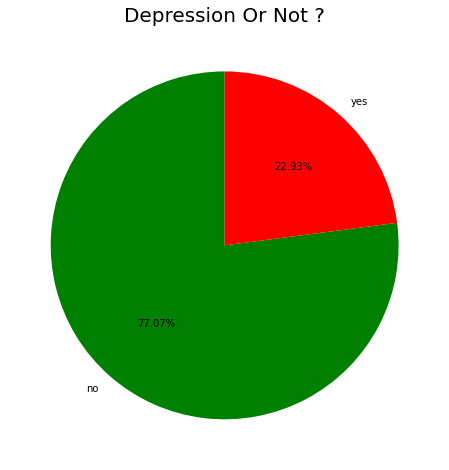

In [11]:


plt.figure(figsize=(10,8))
plt.pie(train_data['label (depression result)'].value_counts(),startangle=90,colors=['green', 'red'],
        autopct='%0.2f%%',labels=['no','yes'])
plt.title('Depression Or Not ?',fontdict={'size':20})
plt.show()
#['#06dddf','#000fbb'],



In [12]:
#Data cleaning
def clean_text(message):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(message):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [13]:
cleaned_train_text,train_text_length=clean_text(train_data.message)
cleaned_test_text,test_text_length=clean_text(test_data.message)

100%|██████████| 2063/2063 [00:00<00:00, 57901.05it/s]


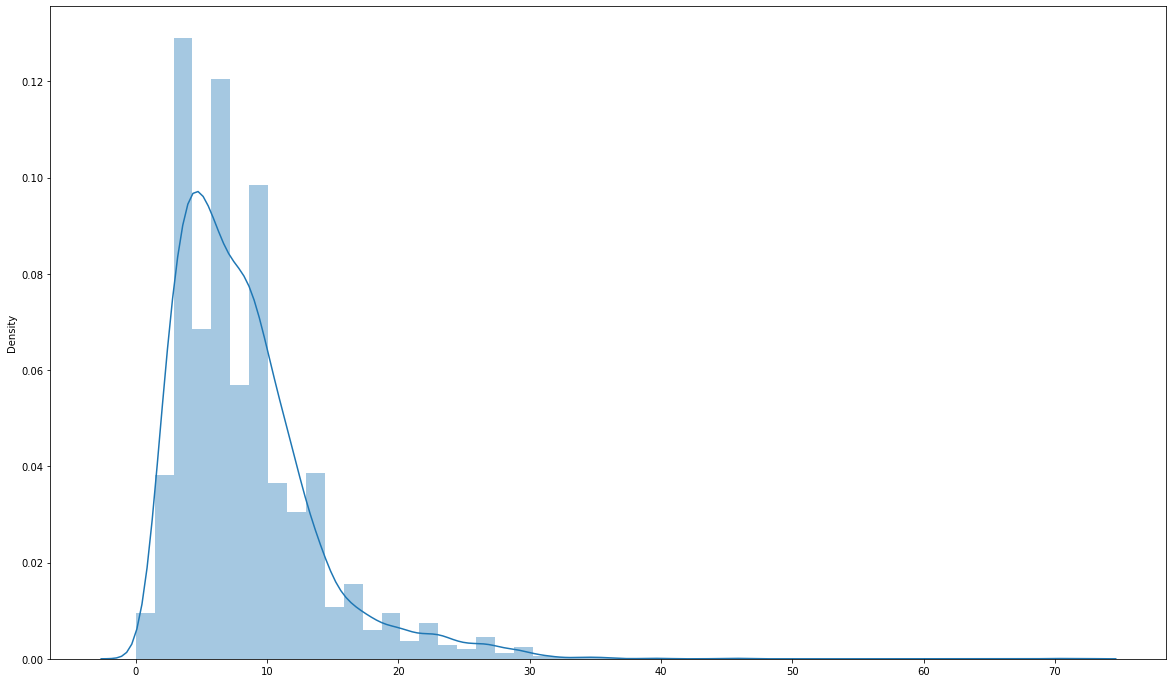

In [14]:


plt.figure(figsize=(20,12))
sns.distplot(train_text_length)
# plt.axis([-10,100,0,0.03])
plt.show()



In [15]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [16]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

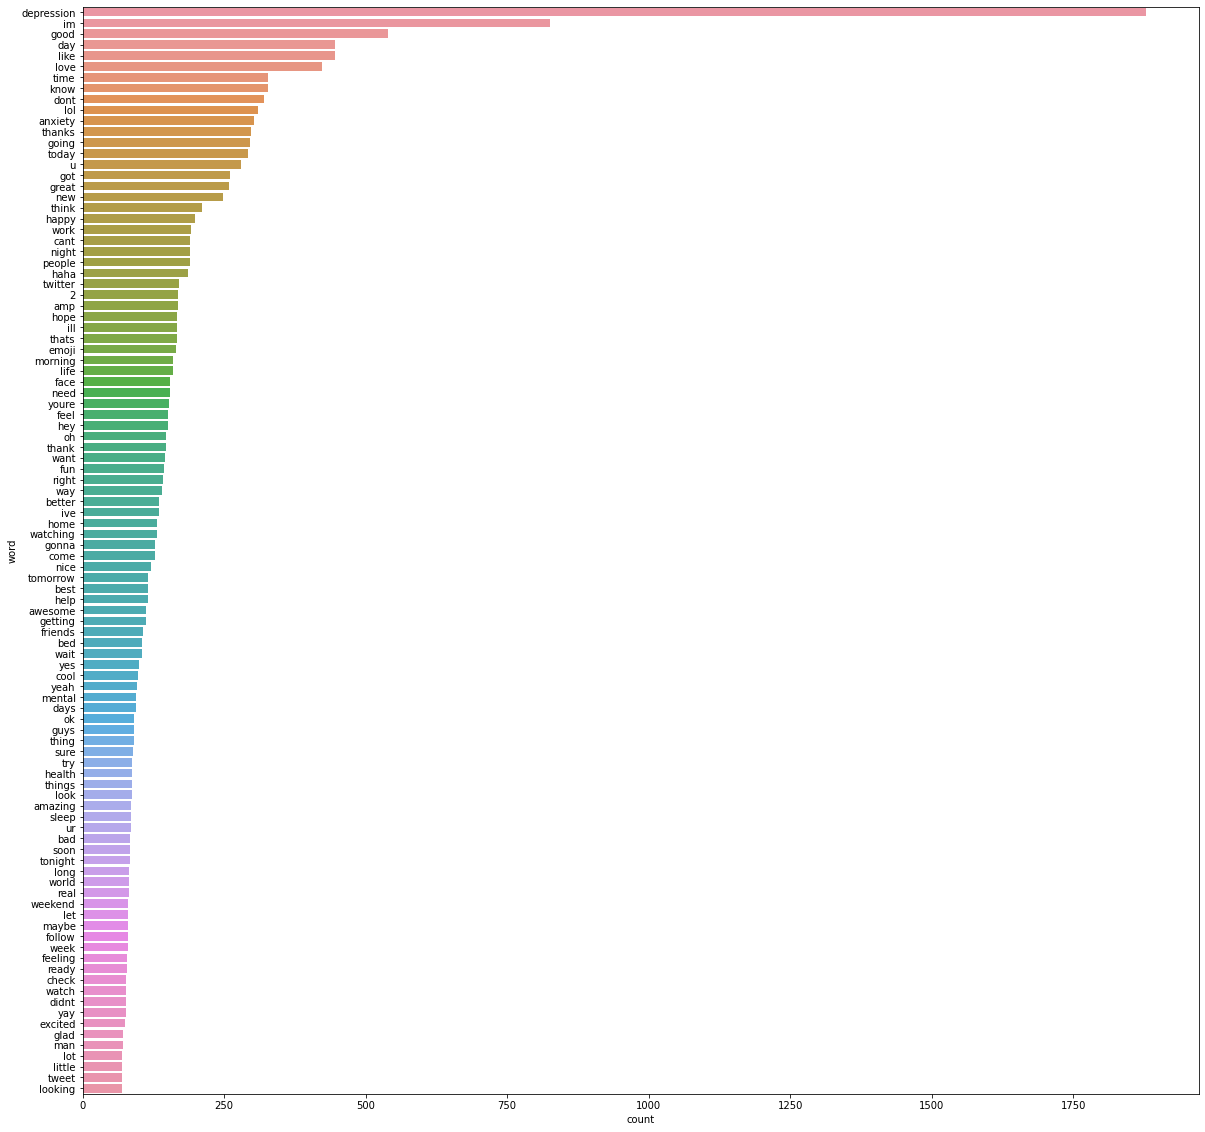

In [17]:
plt.figure(figsize=(20,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:100])
plt.show()

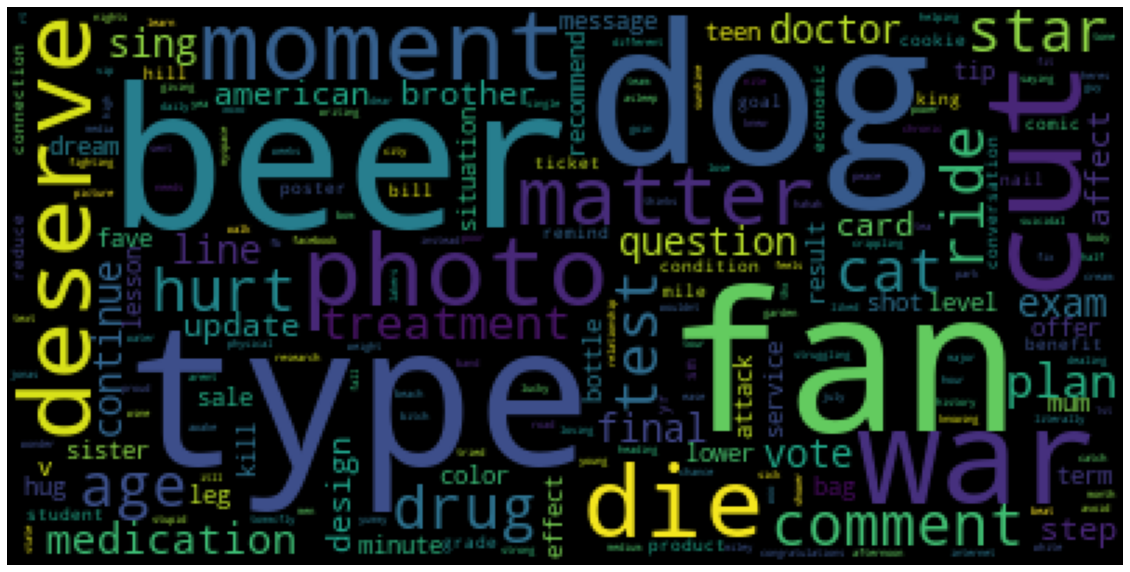

In [18]:
#Not necessary
feature_names=word_freq['word'].values
wc=WordCloud(max_words=200)
wc.generate(' '.join(word for word in feature_names[500:2500] ))
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(wc)
#wc.generate(' '.join(word for word in feature_names[500:3500] ))

In [54]:


tweets = df.values[:,1]
labels = df.values[:,2].astype(float)
print (tweets[45], labels[45])
print (tweets[8005], labels[8005])



@modejunkie awww sweetness! But he's still a cutie!  0.0
my anxiety and my depression fighting over whos day it is  https://twitter.com/crissles/status/988218861697806336Â â¦ 1.0


In [20]:
#!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
bert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [21]:


embeddings = bert_model.encode(tweets, show_progress_bar=True)
print (embeddings.shape)
#embeddings = bert_model.encode(df.message, show_progress_bar=True)
#print (embeddings.shape)


Batches: 100%|██████████| 323/323 [09:43<00:00,  1.81s/it]

(10314, 768)


In [22]:


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, 
                                          test_size=0.2, random_state=42)
print ("Training set shapes:", X_train.shape, y_train.shape)
print ("Test set shapes:", X_test.shape, y_test.shape)



Training set shapes: (8251, 768) (8251,)
Test set shapes: (2063, 768) (2063,)


In [23]:
#I used randomforestclassifier model, so don't know if this is necessary
from tensorflow.keras import Sequential, layers

classifier = Sequential()
classifier.add (layers.Dense(256, activation='relu', input_shape=(768,)))
classifier.add (layers.Dense(1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  
    
hist = classifier.fit (X_train, y_train, epochs=10, batch_size=16, 
                      validation_data=(X_test, y_test))


Epoch 1/10
516/516 [==============================] - 3s 3ms/step - loss: 0.0723 - accuracy: 0.9731 - val_loss: 0.0652 - val_accuracy: 0.9762
Epoch 2/10
516/516 [==============================] - 2s 3ms/step - loss: 0.0380 - accuracy: 0.9862 - val_loss: 0.0399 - val_accuracy: 0.9874
Epoch 3/10
516/516 [==============================] - 2s 4ms/step - loss: 0.0257 - accuracy: 0.9916 - val_loss: 0.0445 - val_accuracy: 0.9869
Epoch 4/10
516/516 [==============================] - 2s 4ms/step - loss: 0.0236 - accuracy: 0.9915 - val_loss: 0.0346 - val_accuracy: 0.9874
Epoch 5/10
516/516 [==============================] - 2s 4ms/step - loss: 0.0168 - accuracy: 0.9949 - val_loss: 0.0360 - val_accuracy: 0.9889
Epoch 6/10
516/516 [==============================] - 2s 4ms/step - loss: 0.0106 - accuracy: 0.9959 - val_loss: 0.0444 - val_accuracy: 0.9855
Epoch 7/10
516/516 [==============================] - 2s 3ms/step - loss: 0.0152 - accuracy: 0.9945 - val_loss: 0.0440 - val_accuracy: 0.9869
Epoch 

In [27]:

#embeddings = bert_model.encode(df.message, show_progress_bar=True)
#print (embeddings.shape)


Batches: 100%|██████████| 323/323 [10:27<00:00,  1.94s/it]


(10314, 768)


In [25]:
embeddings

array([[-0.88297683,  0.045337  ,  1.038359  , ..., -0.28533867,
        -0.02419497, -0.21043606],
       [-0.43105194, -0.7311447 ,  0.6841728 , ...,  0.16172639,
         0.17172974, -0.6560318 ],
       [ 0.22631957, -0.38629708,  0.8538063 , ...,  0.02654455,
        -0.205984  ,  0.02080384],
       ...,
       [-0.2663838 , -0.32669133,  0.7152725 , ..., -0.10697744,
        -0.41044775,  0.29736015],
       [-0.87485933, -0.20091745,  0.28983176, ..., -0.26827544,
         0.05667134, -0.21770394],
       [-1.1190494 , -0.08939341,  0.03098689, ..., -0.17223687,
        -0.19136567,  0.36089864]], dtype=float32)

In [26]:
X = embeddings
y = df['label (depression result)']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#20% better

In [28]:
from sklearn.ensemble import RandomForestClassifier
fit = RandomForestClassifier().fit(X_train, y_train)

In [37]:
print("The accuracy is : ")
np.sum(fit.predict(X_test)==y_test)/len(y_test)

The accuracy is : 


0.9665535627726611

In [46]:
[fit.predict([bert_model.encode("the worst sadness is the sadness you've taught yourself to hide.")])]
#[fit.predict([bert_model.encode('the worst sadness is the sadness you've taught yourself to hide.')])

[array([1])]

In [44]:
words = np.array(['not depressed', 'depressed'])

In [42]:
words[fit.predict([bert_model.encode("the worst sadness is the sadness you've taught yourself to hide.")])]
#[fit.predict([bert_model.encode('the worst sadness is the sadness you've taught yourself to hide.')])]

array(['depressed'], dtype='<U13')

In [47]:
print("The outcome is: ")
print(words[fit.predict([bert_model.encode("If you choose to define me by my mistakes, Remember redemption doesn't fall down at your feet.")])].squeeze())
print(words[fit.predict([bert_model.encode("the worst sadness is the sadness you've taught yourself to hide.")])].squeeze())

The outcome is: 
not depressed
depressed
